# MIND News Recommendation System

## Architecture Overview:
1. **News Encoder:** BERT/RoBERTa + Attention Pooling (Title → Vector)
2. **User Encoder:** Attention Pooling over history (History → User Vector)
3. **Prediction:** Dot product similarity + Softmax
4. **Training:** Negative Sampling with Cross-Entropy Loss

## Pipeline:
```
User History → News Encoder → User Encoder → User Vector
                                                  ↓
Candidate News → News Encoder → Candidate Vectors → Dot Product → Click Probability
```


## Import Libraries


In [4]:
%pip install --quiet -r requirements.txt

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from src import *

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("All libraries imported successfully!")


Note: you may need to restart the kernel to use updated packages.
All libraries imported successfully!


## Configuration


In [2]:
print_config()

CONFIGURATION
MODEL_TYPE           : miner
NEWS_TRAIN_PATH      : /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_train/news.tsv
NEWS_VAL_PATH        : /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_dev/news.tsv
BEHAVIORS_TRAIN_PATH : /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_train/behaviors.tsv
BEHAVIORS_VAL_PATH   : /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_dev/behaviors.tsv
CHECKPOINT_PATH      : /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/mind_news_rec.pth
MODEL_NAME           : xlnet-base-cased
EMBEDDING_DIM        : 768
ATTENTION_QUERY_DIM  : 200
MAX_TITLE_LEN        : 10
MAX_HISTORY_LEN      : 20
NEG_SAMPLES          : 4
BATCH_SIZE           : 8
EPOCHS               : 3
LR                   : 4e-05
DEVICE               : mps
LOAD_CHECKPOINT      : True
DEBUG_SUBSET_SIZE    : 100
NUM_INTERESTS        : 4
I

## Download dataset from Kaggle

In [3]:
# download_dataset()

## News


### Load and Explore News Data


In [4]:
news_df = load_news_data()

print(f"\nNews Articles Samples:")
news_df.head(10)

Loading News Articles from /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_train/news.tsv and /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_dev/news.tsv...
  Training news: 51,282 articles
  Validation news: 42,416 articles
Loaded 65,238 unique news articles (combined)

News Articles Samples:


,news_id,title
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,50 Worst Habits For Belly Fat
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,I Was An NBA Wife. Here's How It Affected My M...
4,N38324,"How to Get Rid of Skin Tags, According to a De..."
5,N2073,Should NFL be able to fine players for critici...
6,N49186,It's been Orlando's hottest October ever so fa...
7,N59295,Chile: Three die in supermarket fire amid prot...
8,N24510,Best PS5 games: top PlayStation 5 titles to lo...
9,N39237,"How to report weather-related closings, delays"


### Tokenize News Articles


In [5]:
print(f"Initializing tokenizer: {config['MODEL_NAME']}...")
news_features = tokenize_news(news_df)
print(f"Tokenized {len(news_features):,} news articles (including <PAD>)")


Initializing tokenizer: xlnet-base-cased...


Tokenizing: 100%|██████████| 65238/65238 [00:07<00:00, 8346.19it/s]

Tokenized 65,239 news articles (including <PAD>)


## Create Training Samples


In [6]:
print("Creating training samples...")
print(f"Strategy: 1 positive + {config['NEG_SAMPLES']} negative samples per training example")

train_behaviors_df, val_behaviors_df = load_behaviors_data()

train_samples = create_behavior_samples(train_behaviors_df, 'train')
val_samples = create_behavior_samples(val_behaviors_df, 'val')

print(f"\nCreated {len(train_samples):,} training samples from {config['BEHAVIORS_TRAIN_PATH']}")
print(f"Created {len(val_samples):,} validation samples from {config['BEHAVIORS_VAL_PATH']}")

Creating training samples...
Strategy: 1 positive + 4 negative samples per training example
Training dataset path: /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_train/behaviors.tsv
Validation dataset path: /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_dev/behaviors.tsv
DEBUG MODE: Using 100 train and 100 val behaviors


Creating val samples: 100%|██████████| 100/100 [00:00<00:00, 62620.24it/s]


Created 137 training samples from /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_train/behaviors.tsv
Created 100 validation samples from /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/MIND/MINDsmall_dev/behaviors.tsv


## Create PyTorch Dataset and DataLoader


In [7]:
class NewsDataset(Dataset):
    """PyTorch Dataset for news recommendation"""
    def __init__(self, samples, news_features, config):
        self.samples = samples
        self.news_features = news_features
        self.config = config
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Process history
        history_ids = sample['history']
        # Pad if shorter than max length
        if len(history_ids) < self.config['MAX_HISTORY_LEN']:
            history_ids = history_ids + ['<PAD>'] * (self.config['MAX_HISTORY_LEN'] - len(history_ids))
        
        # Stack history features
        hist_input_ids = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['input_ids'] 
            for nid in history_ids
        ])
        hist_attn_mask = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['attention_mask'] 
            for nid in history_ids
        ])
        
        # Process candidates
        candidate_ids = sample['candidates']
        cand_input_ids = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['input_ids'] 
            for nid in candidate_ids
        ])
        cand_attn_mask = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['attention_mask'] 
            for nid in candidate_ids
        ])
        
        return {
            'history_input_ids': hist_input_ids,
            'history_attn_mask': hist_attn_mask,
            'candidate_input_ids': cand_input_ids,
            'candidate_attn_mask': cand_attn_mask,
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }

# Create datasets
print("Creating PyTorch datasets...")
train_dataset = NewsDataset(train_samples, news_features, config)
val_dataset = NewsDataset(val_samples, news_features, config)

print(f"Train dataset: {len(train_dataset):,} samples")
print(f"Validation dataset: {len(val_dataset):,} samples")

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['BATCH_SIZE'], 
    shuffle=True,
    num_workers=0  # Set to 0 to avoid multiprocessing issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,  # Variable number of candidates per sample
    shuffle=False,
    num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Creating PyTorch datasets...
Train dataset: 137 samples
Validation dataset: 100 samples
Train batches: 18
Validation batches: 100


## Initialize Model


In [8]:
model = get_model(config['MODEL_TYPE'], config).to(config['DEVICE'])

# for param in model.news_encoder.embedding.parameters():
#     param.requires_grad = False

# # Unfreeze only the last N transformer layers
# num_layers_to_unfreeze = 2  # Adjust this (try 1-3)
# for layer in model.news_encoder.embedding.encoder.layer[-num_layers_to_unfreeze:]:
#     for param in layer.parameters():
#         param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=config['LR'])
# optimizer = torch.optim.AdamW([
#     # Pretrained RoBERTa - lower learning rate
#     {'params': model.news_encoder.embedding.parameters(), 'lr': 1e-5},
#     # Custom attention layers - higher learning rate
#     {'params': model.news_encoder.attention_pooling.parameters(), 'lr': 1e-4},
#     {'params': model.user_attention.parameters(), 'lr': 1e-4}
# ], weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

print(f"Model initialized on {config['DEVICE']}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized on mps
Total parameters: 122,785,936
Trainable parameters: 122,785,936


## Train the Model


In [9]:
train_model(model, train_loader, val_loader, optimizer, criterion, config['DEVICE'])

Loading checkpoint from /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/mind_news_rec.pth...
Resuming training from epoch 4
TRAINING FOR 3 EPOCHS


Epoch 4/6


Training: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s, loss=0.0995] 


Training Loss: 7.4581


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Validation Metrics:
  AUC: 0.4877
  MRR: 0.2152
  NDCG@5: 0.2178
  NDCG@10: 0.2771
Model checkpoint saved to /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/mind_news_rec.pth


Epoch 5/6


Training: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s, loss=6.9021] 


Training Loss: 6.7575


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Validation Metrics:
  AUC: 0.4922
  MRR: 0.2129
  NDCG@5: 0.2150
  NDCG@10: 0.2805
Model checkpoint saved to /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/mind_news_rec.pth


Epoch 6/6


Training: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s, loss=15.7230]


Training Loss: 6.5781


Evaluating: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


Validation Metrics:
  AUC: 0.5004
  MRR: 0.2109
  NDCG@5: 0.2061
  NDCG@10: 0.2796
Model checkpoint saved to /Users/lenhathoang/Developer/HUST Projects/mind-news-recommendation/mind_news_rec.pth

TRAINING COMPLETE!
Final Training Loss: 6.5781
Best Validation AUC: 0.5135


## Training Results

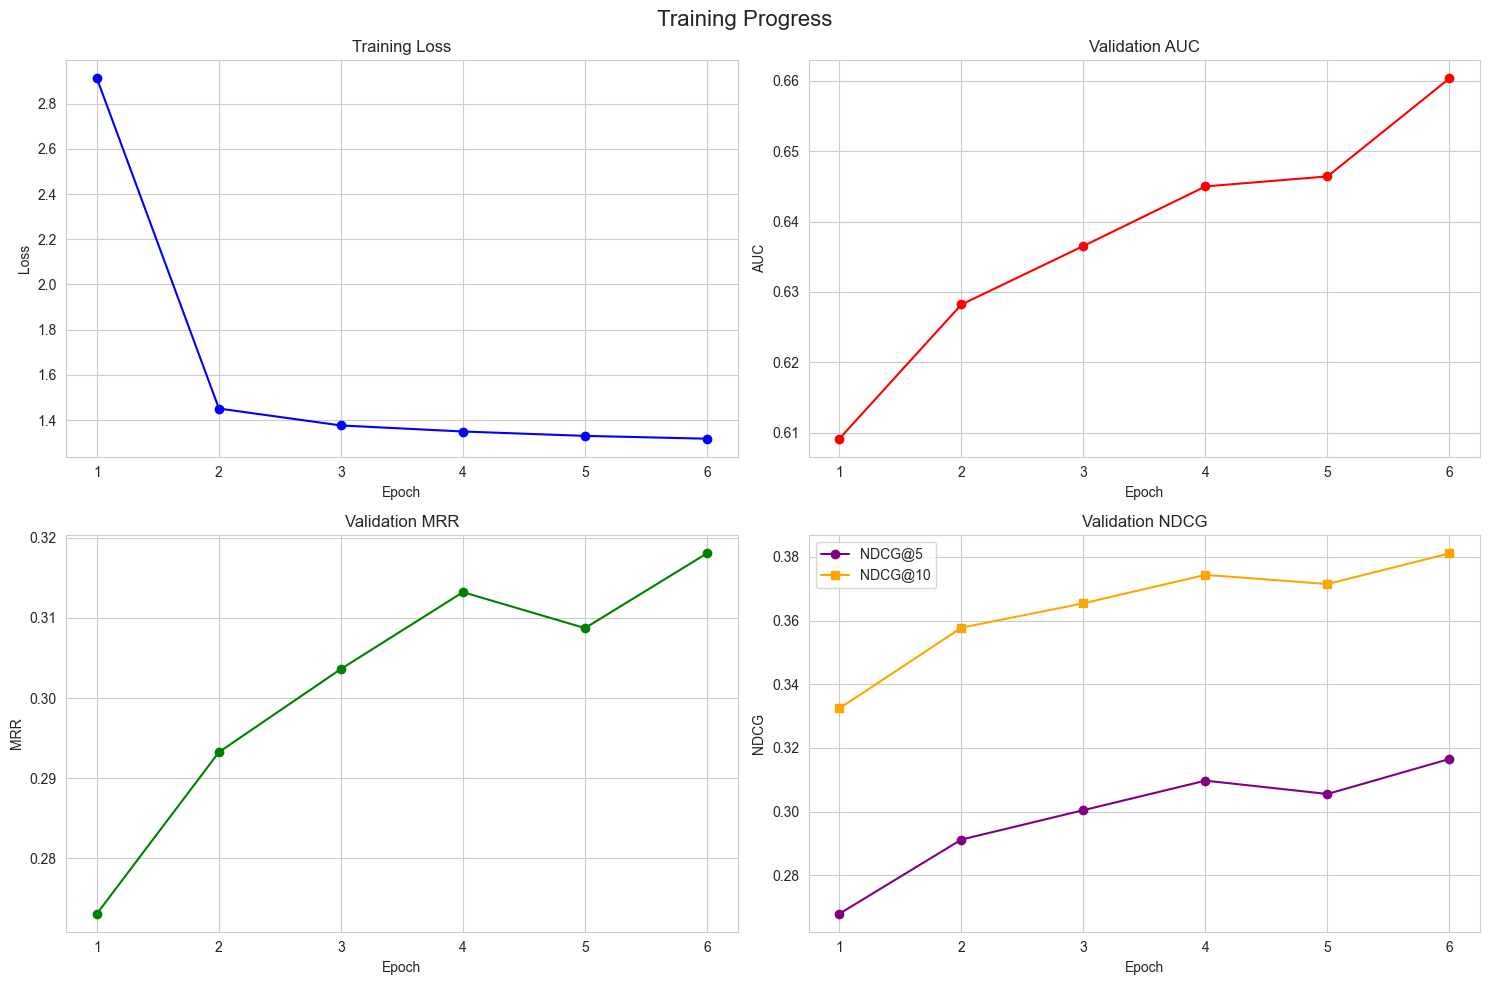


Final Training Results:
Final Training Loss: 1.3178
Best Validation AUC: 0.6604
Best Validation MRR: 0.3181
Best Validation NDCG@5: 0.3165
Best Validation NDCG@10: 0.3811

Loss per Epoch:
Epoch  1: 2.911519
Epoch  2: 1.451146
Epoch  3: 1.376381
Epoch  4: 1.349604
Epoch  5: 1.330268
Epoch  6: 1.317778

Model Configuration:
MODEL_TYPE                : nrms
NEWS_TRAIN_PATH           : /workspace/mind-news-recommendation/MIND/MINDsmall_train/news.tsv
NEWS_VAL_PATH             : /workspace/mind-news-recommendation/MIND/MINDsmall_dev/news.tsv
BEHAVIORS_TRAIN_PATH      : /workspace/mind-news-recommendation/MIND/MINDsmall_train/behaviors.tsv
BEHAVIORS_VAL_PATH        : /workspace/mind-news-recommendation/MIND/MINDsmall_dev/behaviors.tsv
CHECKPOINT_PATH           : /workspace/mind-news-recommendation/mind_news_rec.pth
MODEL_NAME                : roberta-base
EMBEDDING_DIM             : 768
ATTENTION_QUERY_DIM       : 200
MAX_TITLE_LEN             : 25
MAX_HISTORY_LEN           : 40
NEG_SAMPLES

In [5]:
# Load the checkpoint to get training history
checkpoint = torch.load('mind_news_rec.pth', map_location=config['DEVICE'])
history = checkpoint['history']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Progress', fontsize=16)

# Plot training loss
axes[0, 0].plot(history['epoch'], history['train_loss'], 'b-', marker='o')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# Plot validation AUC
axes[0, 1].plot(history['epoch'], history['val_auc'], 'r-', marker='o')
axes[0, 1].set_title('Validation AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].grid(True)

# Plot validation MRR
axes[1, 0].plot(history['epoch'], history['val_mrr'], 'g-', marker='o')
axes[1, 0].set_title('Validation MRR')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MRR')
axes[1, 0].grid(True)

# Plot validation NDCG@5 and NDCG@10
axes[1, 1].plot(history['epoch'], history['val_ndcg@5'], 'purple', marker='o', label='NDCG@5')
axes[1, 1].plot(history['epoch'], history['val_ndcg@10'], 'orange', marker='s', label='NDCG@10')
axes[1, 1].set_title('Validation NDCG')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('NDCG')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Results:")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Best Validation AUC: {max(history['val_auc']):.4f}")
print(f"Best Validation MRR: {max(history['val_mrr']):.4f}")
print(f"Best Validation NDCG@5: {max(history['val_ndcg@5']):.4f}")
print(f"Best Validation NDCG@10: {max(history['val_ndcg@10']):.4f}")

# Print loss values for each epoch
print("\nLoss per Epoch:")
print("=" * 30)
for i, (epoch, loss) in enumerate(zip(history['epoch'], history['train_loss'])):
    print(f"Epoch {epoch:2d}: {loss:.6f}")
print("=" * 30)

# Print model configuration for reference
print("\nModel Configuration:")
print("=" * 50)
for key, value in checkpoint['config'].items():
    print(f"{key:25s} : {value}")
print("=" * 50)